#***Python Code for Face Mask Detection Alert System***

> By: Sajjad Haider Khan

> Coventry University






#**Mount Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


#**Import Libraries**

In [15]:
import numpy as np
from numpy.random import seed
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os, glob
from os import listdir
from os.path import isfile, join
# import xml.etree.ElementTree as et
from google.colab.patches import cv2_imshow
import itertools
from tensorflow.keras.preprocessing.image import img_to_array
!pip install xmltodict #installing the library to read XMl files
import xmltodict
import cv2
import pickle
import random
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.utils import to_categorical
# from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.utils.vis_utils import plot_model
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
# from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.metrics import precision_recall_fscore_support

#**Global Parameters**

In [16]:
num_classes = 3
batch_size = 32
seed(100)
img_rows, img_cols = 224, 224
target_names = ['Class:0 - With Mask', 'Class:1 - Without Mask', 'Class:2 - Mask Weared Incorrect']
cm_plot_labels = ['With Mask', 'Without Mask', 'Mask worn incorrect']

#**Global Functions**

In [4]:
def plot_confusion_matrix(cm, classes, normalize=False, 
                           title='Confusion matrix',
                           cmap=plt.cm.Blues):
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  print(cm)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt), 
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.savefig('_model confusion matrix.png')
  plt.tight_layout()

#**Pre-Processing of 1st raw dataset**

###Code for extracting faces from 1st raw dataset

> containing images and annotations



In [ ]:
def getImageNames():
  image_names = []
  for dirname, _, filenames in os.walk('/content/drive/My Drive/Colab Notebooks/Face Mask Detector/1st Dataset - Raw/'):
    for filename in filenames:
      fullpath = os.path.join(dirname, filename)
      extension = fullpath[len(fullpath) - 4:]
      if extension != '.xml':
        image_names.append(filename)
  return image_names

In [ ]:
getImageNames()[:2]

['maksssksksss8.png', 'maksssksksss7.png']

In [ ]:
def get_path(image_name):
    
  home_path = '/content/drive/My Drive/Colab Notebooks/Face Mask Detector/1st Dataset - Raw/'
  image_path = home_path + 'images/' + image_name
    
  if image_name[-4:] == 'jpeg':
    label_name = image_name[:-5] + '.xml'
  else:
    label_name = image_name[:-4] + '.xml'
    
  label_path = home_path + 'annotations/' + label_name
        
  return  image_path, label_path

In [ ]:
print(get_path('maksssksksss800.png'))

('/content/drive/My Drive/Colab Notebooks/Face Mask Detector/1st Dataset - Raw/images/maksssksksss800.png', '/content/drive/My Drive/Colab Notebooks/Face Mask Detector/1st Dataset - Raw/annotations/maksssksksss800.xml')


In [ ]:
def parse_xml(label_path):
    
  x = xmltodict.parse(open(label_path , 'rb'))
  item_list = x['annotation']['object']
    
  # when image has only one bounding box
  if not isinstance(item_list, list):
    item_list = [item_list]
        
  result = []
    
  for item in item_list:
    name = item['name']
    bndbox = [(int(item['bndbox']['xmin']), int(item['bndbox']['ymin'])),
              (int(item['bndbox']['xmax']), int(item['bndbox']['ymax']))]       
    result.append((name, bndbox))
    
  size = [int(x['annotation']['size']['width']), 
          int(x['annotation']['size']['height'])]
    
  return result, size

In [ ]:
parse_xml('/content/drive/My Drive/Colab Notebooks/Face Mask Detector/1st Dataset - Raw/annotations/maksssksksss388.xml')

([('with_mask', [(26, 92), (44, 121)]),
  ('with_mask', [(106, 88), (122, 111)]),
  ('with_mask', [(122, 102), (146, 124)]),
  ('with_mask', [(151, 73), (168, 94)]),
  ('without_mask', [(168, 76), (190, 100)]),
  ('with_mask', [(188, 96), (219, 131)]),
  ('without_mask', [(192, 59), (210, 78)]),
  ('without_mask', [(223, 53), (243, 76)]),
  ('without_mask', [(272, 67), (291, 88)]),
  ('with_mask', [(260, 93), (279, 115)]),
  ('with_mask', [(288, 86), (308, 113)]),
  ('with_mask', [(348, 71), (366, 91)]),
  ('mask_weared_incorrect', [(303, 96), (330, 123)]),
  ('without_mask', [(371, 77), (396, 100)]),
  ('without_mask', [(68, 75), (80, 88)]),
  ('without_mask', [(321, 70), (333, 84)]),
  ('with_mask', [(367, 67), (378, 79)])],
 [400, 225])

In [ ]:
def visualize_image(image_name, bndbox=True):
  image_path, label_path = get_path(image_name)
    
  image = cv2.imread(image_path)
  #print(image_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
  if bndbox:
    labels, size = parse_xml(label_path)
    thickness = int(sum(size)/400.)
        
    for label in labels:
      name, bndbox = label
            
      if name == 'with_mask':
        cv2.rectangle(image, bndbox[0], bndbox[1], (0, 255, 0), thickness)
      elif name == 'without_mask':
        cv2.rectangle(image, bndbox[0], bndbox[1], (255, 0, 0), thickness)
      else: # name == 'none'
        cv2.rectangle(image, bndbox[0], bndbox[1], (0, 0, 255), thickness)
    
  plt.figure(figsize=(20, 20))
  plt.subplot(1, 2, 1)
  plt.axis('off')
  plt.title(image_name)
  plt.imshow(image)
  plt.show()

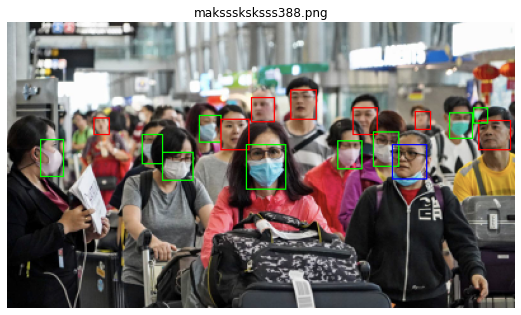

In [ ]:
visualize_image('maksssksksss388.png')

In [ ]:
image_names = getImageNames()
image_names[:2]

['maksssksksss8.png', 'maksssksksss7.png']

/content/drive/My Drive/Colab Notebooks/Face Mask Detector/1st Dataset - Raw/images/maksssksksss2.png
 /content/drive/My Drive/Colab Notebooks/Face Mask Detector/1st Dataset - Raw/annotations/maksssksksss2.xml


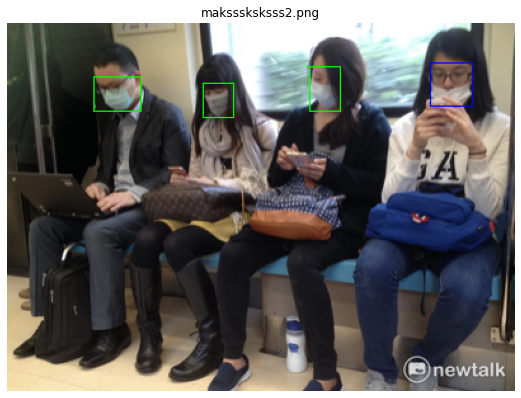

In [ ]:
image_path, label_path = get_path(image_names[4])
print(image_path + '\n', label_path)
visualize_image(image_names[4])

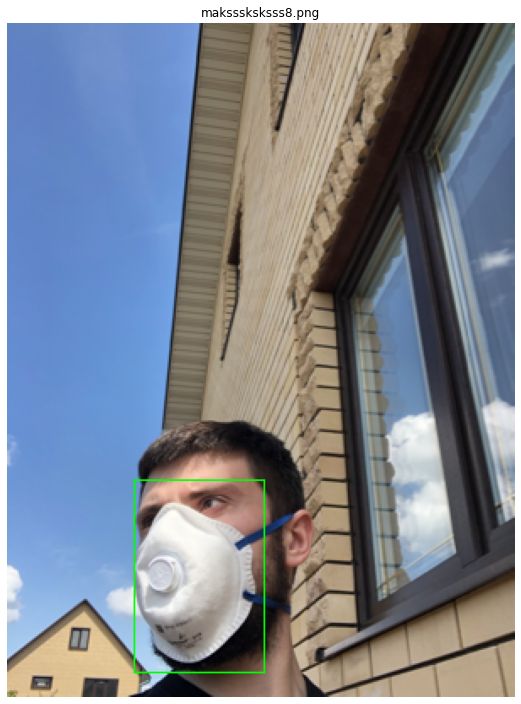

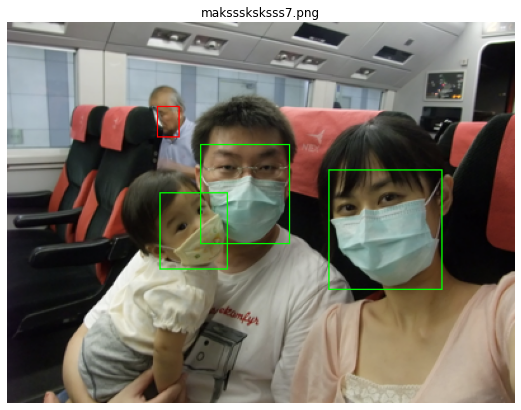

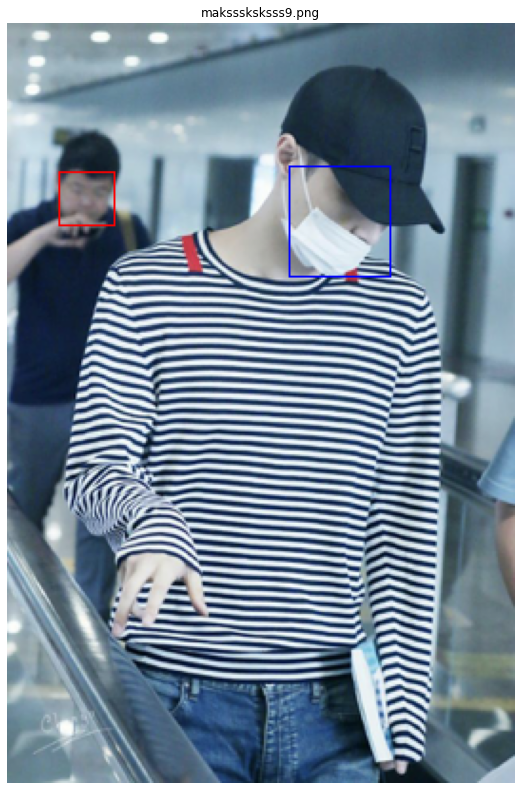

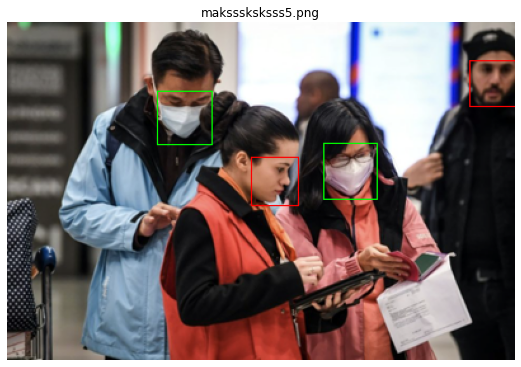

In [ ]:
NUM_OF_IMGS_TO_VISUALIZE = 4

for i in range(0, NUM_OF_IMGS_TO_VISUALIZE):
  visualize_image(image_names[i])

In [ ]:
def cropImage(image_name):
  image_path, label_path = get_path(image_name)
    
  image = cv2.imread(image_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  
  labels, size = parse_xml(label_path)
    
  cropedImgLabels = []

  for label in labels:
    name, bndbox = label
    
    croped_image = image[bndbox[0][1]:bndbox[1][1], bndbox[0][0]:bndbox[1][0]]
    
    label_num = 0
        
    if name == "mask_weared_incorrect":
      label_num = 2
    elif name == "without_mask":
      label_num = 1
    elif name == "with_mask":
      label_num = 0
    else:
      pass
        
    cropedImgLabel = [croped_image, label_num]
        
    cropedImgLabels.append(cropedImgLabel)
        
  return cropedImgLabels

In [ ]:
cropImage('maksssksksss388.png')[0]

[array([[[ 35,  34,  35],
         [ 45,  44,  45],
         [ 37,  39,  38],
         ...,
         [ 27,  34,  39],
         [ 26,  35,  34],
         [ 33,  45,  36]],
 
        [[ 30,  29,  30],
         [ 29,  28,  29],
         [ 33,  33,  33],
         ...,
         [ 31,  35,  34],
         [ 44,  43,  35],
         [ 68,  66,  52]],
 
        [[ 26,  25,  26],
         [ 25,  23,  25],
         [ 31,  28,  27],
         ...,
         [ 53,  51,  40],
         [109,  95,  73],
         [150, 127, 108]],
 
        ...,
 
        [[128,  91,  73],
         [138, 101,  87],
         [136, 105,  98],
         ...,
         [ 39,  41,  38],
         [ 96,  96,  89],
         [135, 133, 122]],
 
        [[112,  79,  65],
         [120,  85,  72],
         [128,  93,  82],
         ...,
         [ 63,  65,  62],
         [117, 117, 110],
         [131, 129, 118]],
 
        [[ 95,  66,  49],
         [100,  70,  56],
         [101,  75,  64],
         ...,
         [ 82,  85,  84],
  

In [ ]:
def createDirectory(dirname):
  try:
    os.mkdir(dirname)
  except FileExistsError:
    print("Directory " + dirname + " already exists.")

In [ ]:
os.chdir("/content/drive/My Drive/Colab Notebooks/Face Mask Detector/Dataset")
dir_name = '853/'
label_0_dir = dir_name + "0/"
label_1_dir = dir_name + "1/"
label_2_dir = dir_name + "2/"
models_dir = "models/"


createDirectory(dir_name)
createDirectory(label_0_dir)
createDirectory(label_1_dir)
createDirectory(label_2_dir)
createDirectory(models_dir)

Directory 853/ already exists.
Directory 853/0/ already exists.
Directory 853/1/ already exists.
Directory 853/2/ already exists.


In [ ]:
label_0_counter = 0
label_1_counter = 0
label_2_counter = 0

for image_name in image_names:
  cropedImgLabels = cropImage(image_name)
    
  for cropedImgLabel in cropedImgLabels:
        
    label = cropedImgLabel[1]
    img = cropedImgLabel[0]
        
    if label == 0:
      croped_img_name = str(label_0_counter) + ".png"
      cv2.imwrite(label_0_dir + croped_img_name, img)
      label_0_counter += 1
    elif label == 1:
      croped_img_name = str(label_1_counter) + ".png"
      cv2.imwrite(label_1_dir + croped_img_name, img)
      label_1_counter += 1
    else:
      croped_img_name = str(label_2_counter) + ".png"
      cv2.imwrite(label_2_dir + croped_img_name, img)
      label_2_counter += 1

In [ ]:
filenames_label_0 = [f for f in listdir(label_0_dir) if isfile(join(label_0_dir, f))]
filenames_label_1 = [f for f in listdir(label_1_dir) if isfile(join(label_1_dir, f))]
filenames_label_2 = [f for f in listdir(label_2_dir) if isfile(join(label_2_dir, f))]

In [ ]:
print("Total number of images: " + str(len(filenames_label_0) + 
                                       len(filenames_label_1) + 
                                       len(filenames_label_2)))
print("Number of images labeled 0: " + str(len(filenames_label_0)))
print("Number of images labeled 1: " + str(len(filenames_label_1)))
print("Number of images labeled 2: " + str(len(filenames_label_2)))

Total number of images: 4072
Number of images labeled 0: 3232
Number of images labeled 1: 717
Number of images labeled 2: 123


In [ ]:
os.chdir("/content/drive/My Drive/Colab Notebooks/Face Mask Detector/Dataset")
Dataset = '853'
Data_Dir = os.listdir(Dataset)
print(Data_Dir)

['0', '1', '2']


In [ ]:
data_853 = []

for category in Data_Dir:
  folder_path = os.path.join(Dataset, category)
  class_num = Data_Dir.index(category)
  
  for image in os.listdir(folder_path):
    new_image_path = os.path.join(folder_path, image)
    image = cv2.imread(new_image_path)
    
    try:
      gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      resized_image = cv2.resize(gray_image, (img_rows, img_cols))
      data_853.append([resized_image, class_num])
    except Exception as e:
      print("Exception:", e)

In [ ]:
print(len(data_853))

4072


In [ ]:
# Data_Dir = list(map(int, Data_Dir))
# Data_Dir

In [ ]:
data_853

[[array([[ 44,  44,  45, ...,  72,  62,  57],
         [ 44,  45,  46, ...,  75,  65,  60],
         [ 45,  46,  47, ...,  77,  68,  64],
         ...,
         [149, 146, 140, ..., 115, 114, 114],
         [153, 151, 146, ..., 115, 114, 114],
         [156, 154, 150, ..., 115, 115, 115]], dtype=uint8), 0],
 [array([[43, 43, 45, ..., 35, 35, 35],
         [43, 43, 45, ..., 35, 35, 35],
         [44, 45, 46, ..., 35, 35, 35],
         ...,
         [48, 48, 48, ..., 72, 75, 75],
         [50, 50, 49, ..., 68, 70, 70],
         [50, 50, 49, ..., 67, 69, 69]], dtype=uint8), 0],
 [array([[ 41,  41,  40, ...,  56,  59,  61],
         [ 40,  40,  40, ...,  56,  59,  61],
         [ 38,  39,  40, ...,  56,  59,  61],
         ...,
         [196, 193, 189, ..., 201, 201, 201],
         [211, 208, 202, ..., 201, 201, 201],
         [216, 212, 206, ..., 201, 201, 201]], dtype=uint8), 0],
 [array([[62, 63, 65, ..., 54, 53, 52],
         [63, 63, 64, ..., 55, 53, 52],
         [64, 64, 64, ..., 57

In [ ]:
random.shuffle(data_853)

In [ ]:
X = []
y = []

In [ ]:
for data,labels in data_853:
  X.append(data)
  y.append(labels)

In [ ]:
print("X is a : ", type(X), '\n')
print("y is a : ", type(y))

X is a :  <class 'list'> 

y is a :  <class 'list'>


In [ ]:
X = np.array(X).reshape(-1, img_rows, img_cols, 1)
X = X/255.0

In [ ]:
y = np.array(y)
y = to_categorical(y)

In [ ]:
# Save the files
pickle_out = open("X_853.pickle", "wb")
pickle.dump(X, pickle_out)
pickle_out.close()

In [ ]:
pickle_out = open("y_853.pickle", "wb")
pickle.dump(y, pickle_out)
pickle_out.close()

In [ ]:
print("Shape of X : ", X.shape, ' & ', "Type :", type(X), '\n')
print("Shape of y : ", y.shape, ' & ', "Type :", type(y))

Shape of X :  (4072, 224, 224, 1)  &  Type : <class 'numpy.ndarray'> 

Shape of y :  (4072, 3)  &  Type : <class 'numpy.ndarray'>


#**Model No. - 1**

> Epochs = 30

> Optimizer = Adam

> Learning Rate = 0.001


##Loading saved pickles of X and y sets

In [ ]:
os.chdir("/content/drive/My Drive/Colab Notebooks/Face Mask Detector/Dataset/")

In [ ]:
# For Loading the dumps
pickle_in = open("X_853.pickle", "rb")
X = pickle.load(pickle_in)

pickle_in = open("y_853.pickle", "rb")
y = pickle.load(pickle_in)

print("Shape of X : ", X.shape, ' & ', "Type :", type(X), '\n')
print("Shape of y : ", y.shape, ' & ', "Type :", type(y))

Shape of X :  (4072, 224, 224, 1)  &  Type : <class 'numpy.ndarray'> 

Shape of y :  (4072, 3)  &  Type : <class 'numpy.ndarray'>


##Train Test Split

In [ ]:
# Model Ratio - Train:Val:Test = 70:10:20

# 80:20 Train:Test
(X_train, X_test, y_train, y_test) = train_test_split(X, 
                                                      y, 
                                                      train_size=0.80, 
                                                      random_state=42)

# Train:Val. We need 70% as training set. So, 70/80 = 0.875 and Val = 1-0.875=0.125 
(X_train, X_val, y_train, y_val) = train_test_split(X_train, 
                                                    y_train, 
                                                    train_size=0.875, 
                                                    random_state=42)

print("Length of Images : {} and Length of Labels : {} \n\nlen(X_train) : {}, len(X_val) : {}, len(X_test) : \
{} \n\nlen(y_train) : {}, len(y_val) : {}, len(y_test) : {}".format(len(X), 
                                                                    len(y),
                                                                    len(X_train), 
                                                                    len(X_val), 
                                                                    len(X_test), 
                                                                    len(y_train), 
                                                                    len(y_val), 
                                                                    len(y_test)))

Length of Images : 4072 and Length of Labels : 4072 

len(X_train) : 2849, len(X_val) : 408, len(X_test) : 815 

len(y_train) : 2849, len(y_val) : 408, len(y_test) : 815


In [ ]:
zero_train = []
one_train = []
two_train = []
zero_val = []
one_val = []
two_val = []
zero_test = []
one_test = []
two_test = []

# Works when the data is in array format
for i in y_train[:,0] == 1.: # Returns Boolean Value
  zero_train.append(i)

for j in y_train[:,1] == 1.:
  one_train.append(j)

for k in y_train[:,2] == 1.:
  two_train.append(k)

for l in y_val[:,0] == 1.:
  zero_val.append(l)

for m in y_val[:,1] == 1.:
  one_val.append(m)

for n in y_val[:,2] == 1.:
  two_val.append(n)

for o in y_test[:,0] == 1.:
  zero_test.append(o)

for p in y_test[:,1] == 1.:
  one_test.append(p)

for q in y_test[:,2] == 1.:
  two_test.append(q)

print("There are "'{:04d}'.format(sum(zero_train)) + " Images in y_train with mask : Label 0") # For counting sum of Boolean Values
print("There are "'{:04d}'.format(sum(one_train)) + " Images in y_train without mask : Label 1") 
print("There are "'{:04d}'.format(sum(two_train)) + " Images in y_train without proper mask : Label 2", '\n')

print("There are "'{:04d}'.format(sum(zero_val)) + " Images in y_val with mask : Label 0") # For counting sum of Boolean Values
print("There are "'{:04d}'.format(sum(one_val)) + " Images in y_val without mask : Label 1") 
print("There are "'{:04d}'.format(sum(two_val)) + " Images in y_val without proper mask : Label 2", '\n')

print("There are "'{:04d}'.format(sum(zero_test)) + " Images in y_test with mask : Label 0") # For counting sum of Boolean Values
print("There are "'{:04d}'.format(sum(one_test)) + " Images in y_test without mask : Label 1") 
print("There are "'{:04d}'.format(sum(two_test)) + " Images in y_test without proper mask : Label 2")

There are 2269 Images in y_train with mask : Label 0
There are 0494 Images in y_train without mask : Label 1
There are 0086 Images in y_train without proper mask : Label 2 

There are 0309 Images in y_val with mask : Label 0
There are 0085 Images in y_val without mask : Label 1
There are 0014 Images in y_val without proper mask : Label 2 

There are 0654 Images in y_test with mask : Label 0
There are 0138 Images in y_test without mask : Label 1
There are 0023 Images in y_test without proper mask : Label 2


##Defining CNN Model

In [ ]:
model = Sequential()

model.add(Conv2D(filters=200, kernel_size=3, input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=100, kernel_size=3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 200)     2000      
_________________________________________________________________
activation (Activation)      (None, 222, 222, 200)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 200)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 100)     180100    
_________________________________________________________________
activation_1 (Activation)    (None, 109, 109, 100)     0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 100)       0         
_________________________________________________________________
flatten (Flatten)            (None, 291600)            0

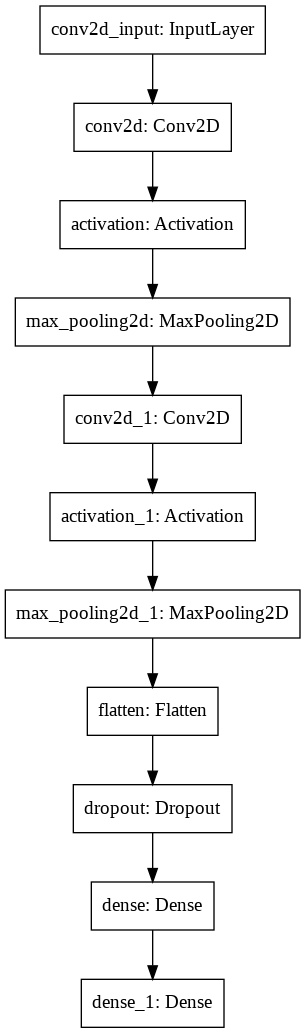

In [ ]:
plot_model(model, to_file='1st_model_architecture.png')

##Compiling model

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics = ['accuracy'])

epochs = 30

m_hist = model.fit(X_train, 
                   y_train, 
                   batch_size=batch_size,
                   epochs=epochs, 
                   verbose=1,
                   validation_data=(X_val, y_val),
                   shuffle=True,
                   steps_per_epoch = X_train.shape[0] // batch_size) # callbacks=[checkpoint]

model.save('models/1st_model.h5')

Epoch 1/30
89/89 [==============================] - 17s 195ms/step - loss: 0.5396 - accuracy: 0.7904 - val_loss: 0.4565 - val_accuracy: 0.7941
Epoch 2/30
89/89 [==============================] - 17s 187ms/step - loss: 0.3908 - accuracy: 0.8523 - val_loss: 0.4033 - val_accuracy: 0.8554
Epoch 3/30
89/89 [==============================] - 17s 186ms/step - loss: 0.3585 - accuracy: 0.8608 - val_loss: 0.3039 - val_accuracy: 0.8897
Epoch 4/30
89/89 [==============================] - 17s 187ms/step - loss: 0.3221 - accuracy: 0.8825 - val_loss: 0.2732 - val_accuracy: 0.9069
Epoch 5/30
89/89 [==============================] - 17s 187ms/step - loss: 0.3131 - accuracy: 0.8857 - val_loss: 0.2798 - val_accuracy: 0.9069
Epoch 6/30
89/89 [==============================] - 17s 186ms/step - loss: 0.2725 - accuracy: 0.9038 - val_loss: 0.3007 - val_accuracy: 0.9020
Epoch 7/30
89/89 [==============================] - 17s 186ms/step - loss: 0.2397 - accuracy: 0.9137 - val_loss: 0.2550 - val_accuracy: 0.9044

##Loading Saved Model

In [ ]:
model = load_model('models/1st_model.h5')

model.compile(loss='categorical_crossentropy', 
              optimizer = Adam(lr=0.001), 
              metrics = ['accuracy'])

In [ ]:
print(m_hist.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [ ]:
print(m_hist.history)

{'loss': [0.5396139025688171, 0.3907582461833954, 0.35854572057724, 0.3220624625682831, 0.3131314516067505, 0.2724604606628418, 0.23967881500720978, 0.24385462701320648, 0.2286875694990158, 0.23250633478164673, 0.19548967480659485, 0.18370437622070312, 0.16048982739448547, 0.13784006237983704, 0.13790391385555267, 0.12042880058288574, 0.10178354382514954, 0.11770109832286835, 0.11027122288942337, 0.0808471068739891, 0.08318822830915451, 0.07495508342981339, 0.10574495792388916, 0.07115079462528229, 0.06162743270397186, 0.05763593316078186, 0.04419153928756714, 0.04051784425973892, 0.04871748387813568, 0.058604881167411804], 'accuracy': [0.7903792262077332, 0.8523251414299011, 0.8608448505401611, 0.882499098777771, 0.8856940269470215, 0.9037983417510986, 0.9137380123138428, 0.9151579737663269, 0.9190628528594971, 0.9183528423309326, 0.9297124743461609, 0.9329073429107666, 0.9414270520210266, 0.9506567120552063, 0.9492367506027222, 0.9563365578651428, 0.9648562073707581, 0.95527154207229

##Results of the model

In [ ]:
scores = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)
print("Test Accuracy : {0:.2f}%".format(scores[1]*100))
print("Loss Value : {0:.4f}".format(scores[0]))

26/26 [==============================] - 2s 76ms/step - loss: 0.5279 - accuracy: 0.8834
Test Accuracy : 88.34%
Loss Value : 0.5279


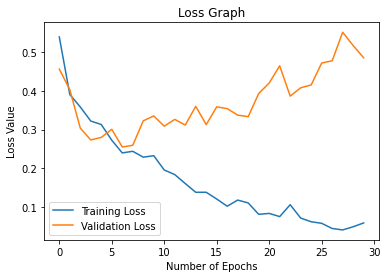

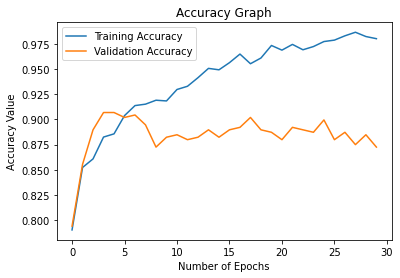

In [ ]:
# Plot Training and Validation Loss
plt.plot(m_hist.history['loss'], label = 'Training Loss')
plt.plot(m_hist.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss Value')
plt.title('Loss Graph')
plt.legend() #(['training', 'validation'], loc='lower right')
plt.show()


# Plot Training and Validation Accuracy
plt.plot(m_hist.history['accuracy'], label = 'Training Accuracy')
plt.plot(m_hist.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy Value')
plt.title('Accuracy Graph')
plt.legend() #(['training', 'validation'], loc='lower right')
plt.show()

In [ ]:
import warnings
warnings.filterwarnings("ignore")

y_pred = model.predict(X_test, batch_size=batch_size, verbose=0)
y_rounded_test = np.argmax(y_test, axis=1)
y_rounded_pred = np.argmax(y_pred, axis=1)

print(classification_report(y_rounded_test, y_rounded_pred, target_names=target_names))
# print('\n')
print(confusion_matrix(y_rounded_test, y_rounded_pred))
print('\n')

# Print f1, precision, and recall scores
print("Macro    : ", precision_recall_fscore_support(y_rounded_test, y_rounded_pred , average="macro"))
print("Micro    : ", precision_recall_fscore_support(y_rounded_test, y_rounded_pred , average="micro"))
print("Weighted : ", precision_recall_fscore_support(y_rounded_test, y_rounded_pred , average="weighted"))

                                 precision    recall  f1-score   support

            Class:0 - With Mask       0.94      0.92      0.93       654
         Class:1 - Without Mask       0.68      0.82      0.74       138
Class:2 - Mask Weared Incorrect       0.56      0.22      0.31        23

                       accuracy                           0.88       815
                      macro avg       0.72      0.65      0.66       815
                   weighted avg       0.89      0.88      0.88       815

[[602  48   4]
 [ 25 113   0]
 [ 12   6   5]]


Macro    :  (0.7247664295821504, 0.6522403935646855, 0.6615504777722837, None)
Micro    :  (0.8834355828220859, 0.8834355828220859, 0.8834355828220859, None)
Weighted :  (0.8862410781421116, 0.8834355828220859, 0.8815055170621032, None)


Confusion matrix, without normalization
[[602  48   4]
 [ 25 113   0]
 [ 12   6   5]]


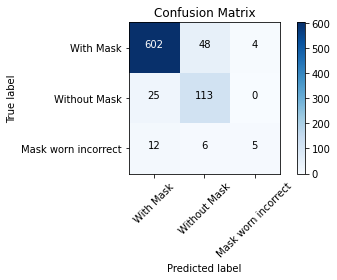

In [ ]:
cm = confusion_matrix(y_rounded_test, y_rounded_pred)

plot_confusion_matrix(cm, cm_plot_labels, title = 'Confusion Matrix')

*As we can see from the confusion matrix, there is very little data in the 'Mask worn incorrect' category. This value is not sufficient for the correct prediction. So, we will try to implement data augmentation to see if the value of this category increases.*

#**Model No. - 2**

> Model No. - 1 with Data Augmentation



##Loading saved pickles of X and y sets

In [ ]:
os.chdir("/content/drive/My Drive/Colab Notebooks/Face Mask Detector/Dataset/")

In [ ]:
# For Loading the dumps
pickle_in = open("X_853.pickle", "rb")
X = pickle.load(pickle_in)

pickle_in = open("y_853.pickle", "rb")
y = pickle.load(pickle_in)

print("Shape of X : ", X.shape, ' & ', "Type :", type(X), '\n')
print("Shape of y : ", y.shape, ' & ', "Type :", type(y))

Shape of X :  (4072, 224, 224, 1)  &  Type : <class 'numpy.ndarray'> 

Shape of y :  (4072, 3)  &  Type : <class 'numpy.ndarray'>


##Train Test Split

In [ ]:
# Model Ratio - Train:Val:Test = 70:10:20

# 80:20 Train:Test
(X_train, X_test, y_train, y_test) = train_test_split(X, 
                                                      y, 
                                                      train_size=0.80, 
                                                      random_state=42)

# Train:Val. We need 70% as training set. So, 70/80 = 0.875 and Val = 1-0.875=0.125 
(X_train, X_val, y_train, y_val) = train_test_split(X_train, 
                                                    y_train, 
                                                    train_size=0.875, 
                                                    random_state=42)

print("Length of Images : {} and Length of Labels : {} \n\nlen(X_train) : {}, len(X_val) : {}, len(X_test) : \
{} \n\nlen(y_train) : {}, len(y_val) : {}, len(y_test) : {}".format(len(X), 
                                                                    len(y),
                                                                    len(X_train), 
                                                                    len(X_val), 
                                                                    len(X_test), 
                                                                    len(y_train), 
                                                                    len(y_val), 
                                                                    len(y_test)))

Length of Images : 4072 and Length of Labels : 4072 

len(X_train) : 2849, len(X_val) : 408, len(X_test) : 815 

len(y_train) : 2849, len(y_val) : 408, len(y_test) : 815


In [ ]:
zero_train = []
one_train = []
two_train = []
zero_val = []
one_val = []
two_val = []
zero_test = []
one_test = []
two_test = []

# Works when the data is in array format
for i in y_train[:,0] == 1.: # Returns Boolean Value
  zero_train.append(i)

for j in y_train[:,1] == 1.:
  one_train.append(j)

for k in y_train[:,2] == 1.:
  two_train.append(k)

for l in y_val[:,0] == 1.:
  zero_val.append(l)

for m in y_val[:,1] == 1.:
  one_val.append(m)

for n in y_val[:,2] == 1.:
  two_val.append(n)

for o in y_test[:,0] == 1.:
  zero_test.append(o)

for p in y_test[:,1] == 1.:
  one_test.append(p)

for q in y_test[:,2] == 1.:
  two_test.append(q)

print("There are "'{:04d}'.format(sum(zero_train)) + " Images in y_train with mask : Label 0") # For counting sum of Boolean Values
print("There are "'{:04d}'.format(sum(one_train)) + " Images in y_train without mask : Label 1") 
print("There are "'{:04d}'.format(sum(two_train)) + " Images in y_train without proper mask : Label 2", '\n')

print("There are "'{:04d}'.format(sum(zero_val)) + " Images in y_val with mask : Label 0") # For counting sum of Boolean Values
print("There are "'{:04d}'.format(sum(one_val)) + " Images in y_val without mask : Label 1") 
print("There are "'{:04d}'.format(sum(two_val)) + " Images in y_val without proper mask : Label 2", '\n')

print("There are "'{:04d}'.format(sum(zero_test)) + " Images in y_test with mask : Label 0") # For counting sum of Boolean Values
print("There are "'{:04d}'.format(sum(one_test)) + " Images in y_test without mask : Label 1") 
print("There are "'{:04d}'.format(sum(two_test)) + " Images in y_test without proper mask : Label 2")

There are 2269 Images in y_train with mask : Label 0
There are 0494 Images in y_train without mask : Label 1
There are 0086 Images in y_train without proper mask : Label 2 

There are 0309 Images in y_val with mask : Label 0
There are 0085 Images in y_val without mask : Label 1
There are 0014 Images in y_val without proper mask : Label 2 

There are 0654 Images in y_test with mask : Label 0
There are 0138 Images in y_test without mask : Label 1
There are 0023 Images in y_test without proper mask : Label 2


##Defining CNN Model

In [ ]:
model = Sequential()

model.add(Conv2D(filters=200, kernel_size=3, input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=100, kernel_size=3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 200)     2000      
_________________________________________________________________
activation (Activation)      (None, 222, 222, 200)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 200)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 100)     180100    
_________________________________________________________________
activation_1 (Activation)    (None, 109, 109, 100)     0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 100)       0         
_________________________________________________________________
flatten (Flatten)            (None, 291600)            0

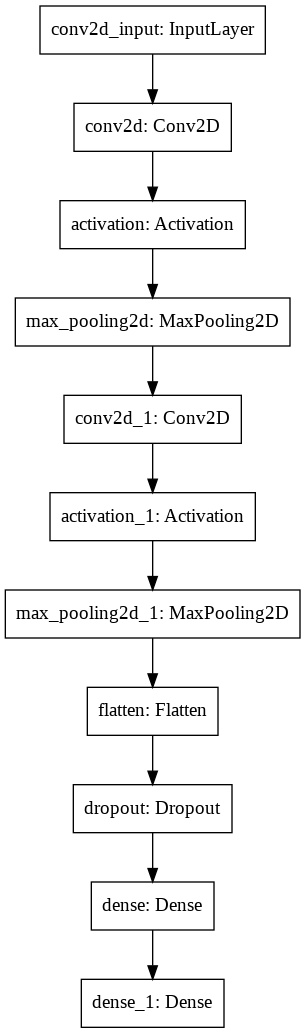

In [ ]:
# Architecture is same as of the 1st model

# plot_model(model, to_file='2nd_model_architecture.png') 

##Compiling model

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics = ['accuracy'])

datagen = ImageDataGenerator(rotation_range=15, 
                             zoom_range=0.2, 
                             width_shift_range=0.2, 
                             height_shift_range=0.2,
                             validation_split=0.20, 
                             horizontal_flip=True)

datagen.fit(X_train)

epochs = 30

m_hist = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                   epochs=epochs, 
                   verbose=1,
                   validation_data=(X_val, y_val),
                   shuffle=True,
                   steps_per_epoch = X_train.shape[0] // batch_size) # callbacks=[checkpoint]

model.save('models/2nd_model.h5')

Epoch 1/30
89/89 [==============================] - 17s 193ms/step - loss: 0.5586 - accuracy: 0.8225 - val_loss: 0.3473 - val_accuracy: 0.8529
Epoch 2/30
89/89 [==============================] - 17s 190ms/step - loss: 0.4310 - accuracy: 0.8385 - val_loss: 0.3204 - val_accuracy: 0.8627
Epoch 3/30
89/89 [==============================] - 17s 191ms/step - loss: 0.4072 - accuracy: 0.8463 - val_loss: 0.3118 - val_accuracy: 0.8946
Epoch 4/30
89/89 [==============================] - 17s 190ms/step - loss: 0.3868 - accuracy: 0.8573 - val_loss: 0.3341 - val_accuracy: 0.8603
Epoch 5/30
89/89 [==============================] - 17s 190ms/step - loss: 0.3793 - accuracy: 0.8605 - val_loss: 0.3157 - val_accuracy: 0.8799
Epoch 6/30
89/89 [==============================] - 17s 190ms/step - loss: 0.3738 - accuracy: 0.8591 - val_loss: 0.2747 - val_accuracy: 0.9020
Epoch 7/30
89/89 [==============================] - 17s 190ms/step - loss: 0.3882 - accuracy: 0.8630 - val_loss: 0.3016 - val_accuracy: 0.8995

##Loading Saved Model

In [ ]:
model = load_model('models/2nd_model.h5')

model.compile(loss='categorical_crossentropy', 
              optimizer = Adam(lr=0.001), 
              metrics = ['accuracy'])

##Results of the model

In [ ]:
scores = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)
print("Test Accuracy : {0:.2f}%".format(scores[1]*100))
print("Loss Value : {0:.4f}".format(scores[0]))

26/26 [==============================] - 2s 65ms/step - loss: 0.2586 - accuracy: 0.9092
Test Accuracy : 90.92%
Loss Value : 0.2586


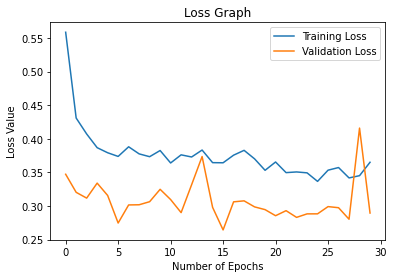

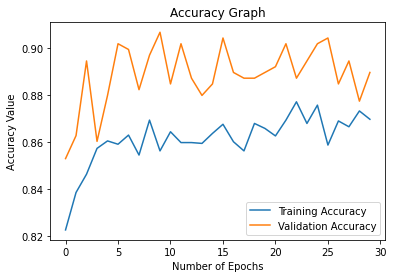

In [ ]:
# Plot Training and Validation Loss
plt.plot(m_hist.history['loss'], label = 'Training Loss')
plt.plot(m_hist.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss Value')
plt.title('Loss Graph')
plt.legend() #(['training', 'validation'], loc='lower right')
plt.show()


# Plot Training and Validation Accuracy
plt.plot(m_hist.history['accuracy'], label = 'Training Accuracy')
plt.plot(m_hist.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy Value')
plt.title('Accuracy Graph')
plt.legend() #(['training', 'validation'], loc='lower right')
plt.show()

In [ ]:
import warnings
warnings.filterwarnings("ignore")

y_pred = model.predict(X_test, batch_size=batch_size, verbose=0)
y_rounded_test = np.argmax(y_test, axis=1)
y_rounded_pred = np.argmax(y_pred, axis=1)

print(classification_report(y_rounded_test, y_rounded_pred, target_names=target_names))
# print('\n')
print(confusion_matrix(y_rounded_test, y_rounded_pred))
print('\n')

# Print f1, precision, and recall scores
print("Macro    : ", precision_recall_fscore_support(y_rounded_test, y_rounded_pred , average="macro"))
print("Micro    : ", precision_recall_fscore_support(y_rounded_test, y_rounded_pred , average="micro"))
print("Weighted : ", precision_recall_fscore_support(y_rounded_test, y_rounded_pred , average="weighted"))

                                 precision    recall  f1-score   support

            Class:0 - With Mask       0.93      0.97      0.95       654
         Class:1 - Without Mask       0.82      0.78      0.80       138
Class:2 - Mask Weared Incorrect       0.00      0.00      0.00        23

                       accuracy                           0.91       815
                      macro avg       0.58      0.58      0.58       815
                   weighted avg       0.88      0.91      0.90       815

[[633  20   1]
 [ 30 108   0]
 [ 20   3   0]]


Macro    :  (0.5837403462497067, 0.5834995346363515, 0.5832900045321462, None)
Micro    :  (0.90920245398773, 0.90920245398773, 0.90920245398773, None)
Weighted :  (0.8833054959377332, 0.90920245398773, 0.8958041919035149, None)


Confusion matrix, without normalization
[[633  20   1]
 [ 30 108   0]
 [ 20   3   0]]


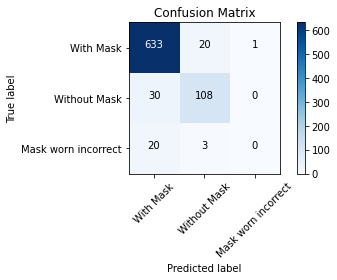

In [ ]:
cm = confusion_matrix(y_rounded_test, y_rounded_pred)

plot_confusion_matrix(cm, cm_plot_labels, title = 'Confusion Matrix')

*With Data Augmentation, value of the 'Mask worn incorrect' category further decreased. For better classification results, we need more data. So, we will add some more data to our data set to increase the number of images in all categories.*

#**Model No. - 3**

##For Pre-Processing of modified (larger) dataset, please see the other jupyter notebook - "Pre-Processing for Model 3 (853_2_3).ipynb"



### Pre-processing of larger dataset is done at local machine due to memory issues (file size > 4GB) in Google Colab. 

## Loading data for compiling the model

In [ ]:
os.chdir("/content/drive/My Drive/Colab Notebooks/Face Mask Detector/Dataset/")

In [ ]:
# For Loading Individual Train Validation Test files
pickle_in = open("X_train_X_853_2_3.pickle", "rb")
X_train = pickle.load(pickle_in)

pickle_in = open("X_val_X_853_2_3.pickle", "rb")
X_val = pickle.load(pickle_in)

pickle_in = open("X_test_X_853_2_3.pickle", "rb")
X_test = pickle.load(pickle_in)

pickle_in = open("y_train_y_853_2_3.pickle", "rb")
y_train = pickle.load(pickle_in)

pickle_in = open("y_val_y_853_2_3.pickle", "rb")
y_val = pickle.load(pickle_in)

pickle_in = open("y_test_y_853_2_3.pickle", "rb")
y_test = pickle.load(pickle_in)

In [ ]:
zero_train = []
one_train = []
two_train = []
zero_val = []
one_val = []
two_val = []
zero_test = []
one_test = []
two_test = []

# Works when the data is in array format
for i in y_train[:,0] == 1.: # Returns Boolean Value
  zero_train.append(i)

for j in y_train[:,1] == 1.:
  one_train.append(j)

for k in y_train[:,2] == 1.:
  two_train.append(k)

for l in y_val[:,0] == 1.:
  zero_val.append(l)

for m in y_val[:,1] == 1.:
  one_val.append(m)

for n in y_val[:,2] == 1.:
  two_val.append(n)

for o in y_test[:,0] == 1.:
  zero_test.append(o)

for p in y_test[:,1] == 1.:
  one_test.append(p)

for q in y_test[:,2] == 1.:
  two_test.append(q)

print("There are "'{:04d}'.format(sum(zero_train)) + " Images in y_train with mask : Label 0") # For counting sum of Boolean Values
print("There are "'{:04d}'.format(sum(one_train)) + " Images in y_train without mask : Label 1") 
print("There are "'{:04d}'.format(sum(two_train)) + " Images in y_train without proper mask : Label 2", '\n')

print("There are "'{:04d}'.format(sum(zero_val)) + " Images in y_val with mask : Label 0") # For counting sum of Boolean Values
print("There are "'{:04d}'.format(sum(one_val)) + " Images in y_val without mask : Label 1") 
print("There are "'{:04d}'.format(sum(two_val)) + " Images in y_val without proper mask : Label 2", '\n')

print("There are "'{:04d}'.format(sum(zero_test)) + " Images in y_test with mask : Label 0") # For counting sum of Boolean Values
print("There are "'{:04d}'.format(sum(one_test)) + " Images in y_test without mask : Label 1") 
print("There are "'{:04d}'.format(sum(two_test)) + " Images in y_test without proper mask : Label 2")

There are 4235 Images in y_train with mask : Label 0
There are 1868 Images in y_train without mask : Label 1
There are 1383 Images in y_train without proper mask : Label 2 

There are 0639 Images in y_val with mask : Label 0
There are 0232 Images in y_val without mask : Label 1
There are 0199 Images in y_val without proper mask : Label 2 

There are 1187 Images in y_test with mask : Label 0
There are 0535 Images in y_test without mask : Label 1
There are 0418 Images in y_test without proper mask : Label 2


##Compiling model

In [ ]:
K.clear_session()

print("Summary :  \n")

model = Sequential()

model.add(Conv2D(filters=64, kernel_size=3, padding="same", activation = 'relu', input_shape=X_train.shape[1:]))
# model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=3, padding="same", activation = 'relu'))
# model.add(Conv2D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=3, padding="same", activation = 'relu'))
# model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))

model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

print(model.summary())

Summary :  

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56,

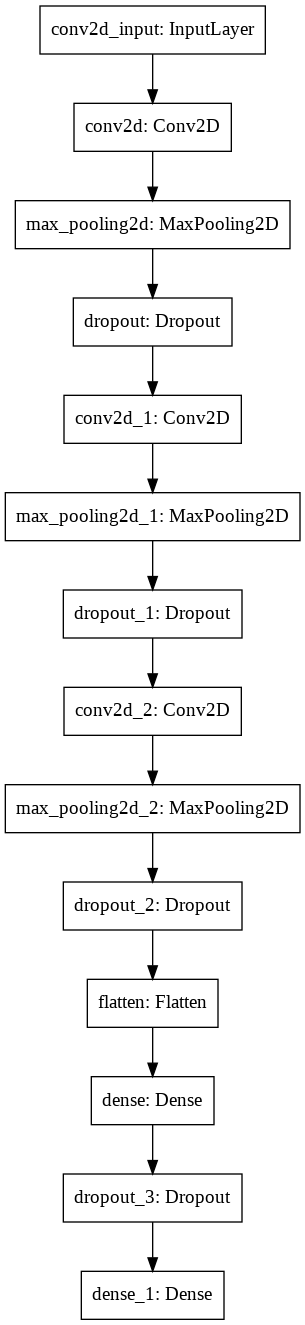

In [ ]:
plot_model(model, to_file='3rd_model_architecture.png')

In [ ]:
model.compile(loss='categorical_crossentropy', 
              optimizer = Adam(lr=0.001), 
              metrics = ['accuracy'])

datagen = ImageDataGenerator(rotation_range=15, 
                             zoom_range=0.2, 
                             width_shift_range=0.2, 
                             height_shift_range=0.2,
                             validation_split=0.20, 
                             horizontal_flip=True)

datagen.fit(X_train)

epochs = 30

m_hist = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                   epochs=epochs, verbose=1,
                   validation_data=(X_val, y_val),
                   shuffle=True,
                   steps_per_epoch = X_train.shape[0] // batch_size) # callbacks=[checkpoint]

model.save('models/3rd_model.h5')

Epoch 1/30
233/233 [==============================] - 49s 212ms/step - loss: 1.0357 - accuracy: 0.5562 - val_loss: 0.8169 - val_accuracy: 0.5981
Epoch 2/30
233/233 [==============================] - 47s 204ms/step - loss: 0.8757 - accuracy: 0.5731 - val_loss: 0.7817 - val_accuracy: 0.6383
Epoch 3/30
233/233 [==============================] - 47s 203ms/step - loss: 0.8326 - accuracy: 0.5923 - val_loss: 0.6692 - val_accuracy: 0.7000
Epoch 4/30
233/233 [==============================] - 48s 204ms/step - loss: 0.7907 - accuracy: 0.6166 - val_loss: 0.6380 - val_accuracy: 0.6860
Epoch 5/30
233/233 [==============================] - 48s 204ms/step - loss: 0.7208 - accuracy: 0.6627 - val_loss: 0.5540 - val_accuracy: 0.7430
Epoch 6/30
233/233 [==============================] - 47s 200ms/step - loss: 0.6445 - accuracy: 0.7171 - val_loss: 0.4704 - val_accuracy: 0.8037
Epoch 7/30
233/233 [==============================] - 47s 201ms/step - loss: 0.5716 - accuracy: 0.7615 - val_loss: 0.4753 - val_ac

##Results of the model

In [ ]:
scores = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)
print("Test Accuracy : {0:.2f}%".format(scores[1]*100))
print("Loss Value : {0:.4f}".format(scores[0]))

67/67 [==============================] - 4s 63ms/step - loss: 0.2326 - accuracy: 0.9131
Test Accuracy : 91.31%
Loss Value : 0.2326


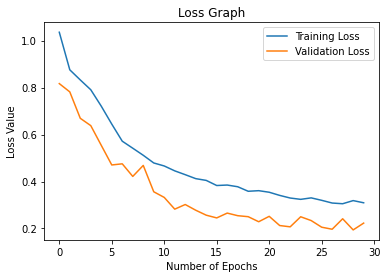

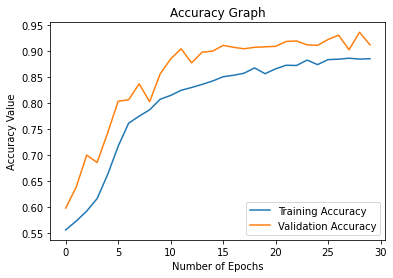

In [ ]:
# Plot Training and Validation Loss
plt.plot(m_hist.history['loss'], label = 'Training Loss')
plt.plot(m_hist.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss Value')
plt.title('Loss Graph')
plt.legend() #(['training', 'validation'], loc='lower right')
plt.show()


# Plot Training and Validation Accuracy
plt.plot(m_hist.history['accuracy'], label = 'Training Accuracy')
plt.plot(m_hist.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy Value')
plt.title('Accuracy Graph')
plt.legend() #(['training', 'validation'], loc='lower right')
plt.show()

In [ ]:
import warnings
warnings.filterwarnings("ignore")

y_pred = model.predict(X_test, batch_size=batch_size, verbose=0)
y_rounded_test = np.argmax(y_test, axis=1)
y_rounded_pred = np.argmax(y_pred, axis=1)

print(classification_report(y_rounded_test, y_rounded_pred, target_names=target_names))
# print('\n')
print(confusion_matrix(y_rounded_test, y_rounded_pred))
print('\n')

# Print f1, precision, and recall scores
print("Macro    : ", precision_recall_fscore_support(y_rounded_test, y_rounded_pred , average="macro"))
print("Micro    : ", precision_recall_fscore_support(y_rounded_test, y_rounded_pred , average="micro"))
print("Weighted : ", precision_recall_fscore_support(y_rounded_test, y_rounded_pred , average="weighted"))

                                 precision    recall  f1-score   support

            Class:0 - With Mask       0.93      0.92      0.92      1187
         Class:1 - Without Mask       0.85      0.89      0.87       535
Class:2 - Mask Weared Incorrect       0.95      0.93      0.94       418

                       accuracy                           0.91      2140
                      macro avg       0.91      0.91      0.91      2140
                   weighted avg       0.91      0.91      0.91      2140

[[1091   80   16]
 [  58  474    3]
 [  23    6  389]]


Macro    :  (0.9102491053304144, 0.911909053199372, 0.9108700837931908, None)
Micro    :  (0.9130841121495327, 0.9130841121495327, 0.9130841121495327, None)
Weighted :  (0.914176126177561, 0.9130841121495327, 0.9134695265619437, None)


Confusion matrix, without normalization
[[1091   80   16]
 [  58  474    3]
 [  23    6  389]]


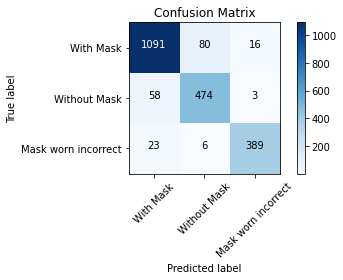

In [ ]:
cm = confusion_matrix(y_rounded_test, y_rounded_pred)

plot_confusion_matrix(cm, cm_plot_labels, title = 'Confusion Matrix')

In [ ]:
(1091+474+389)/2140

0.9130841121495327

##Cross Validation

> loading only train sets for saving memory space



In [ ]:
os.chdir("/content/drive/My Drive/Colab Notebooks/Face Mask Detector/Dataset/")

In [ ]:
# For Loading Train files
pickle_in = open("X_train_X_853_2_3.pickle", "rb")
X_train = pickle.load(pickle_in)

pickle_in = open("y_train_y_853_2_3.pickle", "rb")
y_train = pickle.load(pickle_in)

In [ ]:
model = load_model('models/3rd_model.h5')

model.compile(loss='categorical_crossentropy', 
              optimizer = Adam(lr=0.001), 
              metrics = ['accuracy'])

In [ ]:
def base_model():
  model = Sequential()

  model.add(Conv2D(filters=64, kernel_size=3, padding="same", activation = 'relu', input_shape=X_train.shape[1:]))
  model.add(MaxPooling2D(pool_size=2))
  model.add(Dropout(0.25))

  model.add(Conv2D(filters=128, kernel_size=3, padding="same", activation = 'relu'))
  model.add(MaxPooling2D(pool_size=2))
  model.add(Dropout(0.25))

  model.add(Conv2D(filters=64, kernel_size=3, padding="same", activation = 'relu'))
  model.add(MaxPooling2D(pool_size=2))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(512, activation='relu'))

  model.add(Dropout(0.5))
  model.add(Dense(3, activation='softmax'))

  model.compile(loss='categorical_crossentropy', 
                optimizer = Adam(lr=0.001), 
                metrics = ['accuracy'])

  return model


classifier = KerasClassifier(build_fn=base_model, epochs=15, batch_size=batch_size, verbose=1)
kfold = KFold(n_splits=5, shuffle=True)
cross_val_results = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv=kfold)
print('\n', cross_val_results)

Epoch 1/15
188/188 [==============================] - 34s 182ms/step - loss: 0.8176 - accuracy: 0.6323
Epoch 2/15
188/188 [==============================] - 34s 182ms/step - loss: 0.4907 - accuracy: 0.7949
Epoch 3/15
188/188 [==============================] - 34s 181ms/step - loss: 0.4102 - accuracy: 0.8328
Epoch 4/15
188/188 [==============================] - 34s 181ms/step - loss: 0.3484 - accuracy: 0.8604
Epoch 5/15
188/188 [==============================] - 34s 181ms/step - loss: 0.3202 - accuracy: 0.8763
Epoch 6/15
188/188 [==============================] - 34s 181ms/step - loss: 0.2795 - accuracy: 0.8913
Epoch 7/15
188/188 [==============================] - 34s 181ms/step - loss: 0.2371 - accuracy: 0.9060
Epoch 8/15
188/188 [==============================] - 34s 181ms/step - loss: 0.1945 - accuracy: 0.9287
Epoch 9/15
188/188 [==============================] - 34s 181ms/step - loss: 0.1858 - accuracy: 0.9319
Epoch 10/15
188/188 [==============================] - 34s 181ms/step - l

In [ ]:
print('\n', "Accuracy: %.2f%% (+/- %.2f%%)" % (cross_val_results.mean()*100, cross_val_results.std()*100))


 Accuracy: 91.04% (+/- 1.15%)


##Predictions



In [ ]:
def predict_image(input_image):
  test_image = cv2.imread(input_image)
  test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
  test_image = cv2.resize(test_image, (img_rows,img_cols))
  cv2_imshow(test_image)
  test_image = image.img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis = 0)
  result = model.predict(test_image)
  label = np.argmax(result, axis=1)[0]
  categories = {0:'With_Mask', 1:'Without_Mask', 2:'With_Incorrect_Mask'}
  print('        ', result, '        ', categories[label])
  return

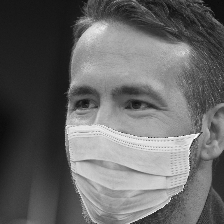

         [[1. 0. 0.]]          With_Mask


In [ ]:
predict_image('Test_images/44150_Mask.jpg')

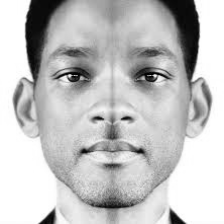

         [[1. 0. 0.]]          With_Mask


In [ ]:
predict_image('Test_images/210.jpg')

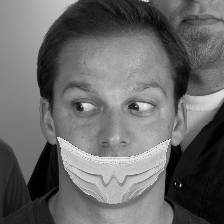

         [[1. 0. 0.]]          With_Mask


In [ ]:
predict_image('Test_images/45022_Mask_Mouth_Chin.jpg')

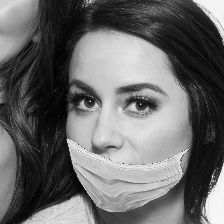

         [[1. 0. 0.]]          With_Mask


In [ ]:
predict_image('Test_images/48009_Mask_Mouth_Chin.jpg')

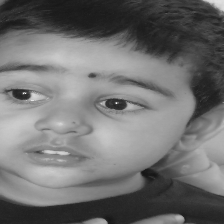

         [[1. 0. 0.]]          With_Mask


In [ ]:
predict_image('Test_images/IMG_20170218_140620.jpg')

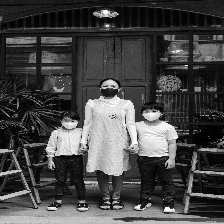

         [[1. 0. 0.]]          With_Mask


In [ ]:
predict_image('Test_images/test8.jpg')

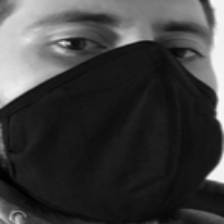

         [[1. 0. 0.]]          With_Mask


In [ ]:
predict_image('Test_images/test1.png')

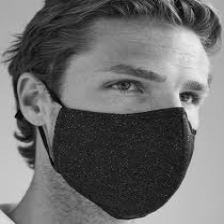

         [[1. 0. 0.]]          With_Mask


In [ ]:
predict_image('Test_images/test3.jpg')

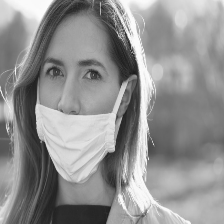

         [[1. 0. 0.]]          With_Mask


In [ ]:
predict_image('Test_images/test4.jpg')

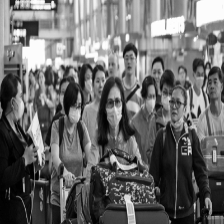

         [[1. 0. 0.]]          With_Mask


In [ ]:
predict_image('Test_images/maksssksksss388.png')

In [ ]:
# def predict_result(test_image):
  
#   test_start = cv2.imread(test_image)
#   cv2_imshow(test_start)
#   test_gray = cv2.cvtColor(test_start, cv2.COLOR_BGR2GRAY)
#   resized = cv2.resize(test_gray, (112,112))
#   normalized_img1 = resized/255.0
#   reshaped_img1 = np.reshape(normalized_img1, (1,112,112,1))  # 224,224,3))
#   result = model.predict(reshaped_img1)

#   return result

In [ ]:
# Saving files for future use

# pickle_out = open("X_train_set_of_X_853.pickle", "wb")
# pickle.dump(X_train, pickle_out)
# pickle_out.close()

# pickle_out = open("X_val_set_of_X_853.pickle", "wb")
# pickle.dump(X_val, pickle_out)
# pickle_out.close()

# pickle_out = open("X_test_set_of_X_853.pickle", "wb")
# pickle.dump(X_test, pickle_out)
# pickle_out.close()

# pickle_out = open("y_train_set_of_y_853.pickle", "wb")
# pickle.dump(y_train, pickle_out)
# pickle_out.close()

# pickle_out = open("y_val_set_of_y_853.pickle", "wb")
# pickle.dump(y_val, pickle_out)
# pickle_out.close()

# pickle_out = open("y_test_set_of_y_853.pickle", "wb")
# pickle.dump(y_test, pickle_out)
# pickle_out.close()

In [ ]:
# np.save("full_data_224x224_list_format_shuffled.npy", full_data_224x224)

# full_data_224x224 = np.load("full_data_224x224_list_of_list_format_shuffled.npy", allow_pickle=True)

In [ ]:
# Code for 112x112 lists

# Already saved. No need to run again. Change the name of the saved files in computer
# np.save("images_list.npy", images_list)
# np.save("labels_list.npy", labels_list)

# Run from here
# images_list = []
# labels_list = []
# images_list = np.load("images_list.npy")
# labels_list = np.load("labels_list.npy")
# images_list = np.array(images_list)/255.0
# images_list = np.resize(images_list, (images_list.shape[0], img_rows, img_cols, 1))
# labels_list = to_categorical(labels_list)
# labels_list = np.array(labels_list)

# print(labels_list.shape)
# print(type(labels_list))

# print(labels_list[:5],'\n')
# print(labels_list[3232:3236],'\n')
# print(labels_list[3949:3953])
# Till here

# Extras
# np.savetxt("labels_list.txt", labels_list,delimiter=',')
# np.savetxt('labels_list.txt', labels_list, fmt='%5s', delimiter=',')
# np.savetxt('labels_list.csv', labels_list, delimiter=',', fmt='%f', header=None)
# np.savetxt('labels_list.csv', labels_list, fmt='%.18e', delimiter=' ', newline='\n', header='', footer='', comments='# ', encoding=None)


In [ ]:
# Saving list to directory
# import csv
# with open(y, 'w', newline='') as myfile:
#   wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
#   wr.writerow(mylist)


# Saving array to directory - 1st method
# np.savetxt("y.csv", y, delimiter=",")

# Saving array to directory - 2nd method - Saves in one row and nultiple cols
# y.tofile('y.csv', sep=',',format='%10.5f')

In [ ]:
# Save the files
pickle_out = open("X_6647.pickle", "wb")
pickle.dump(X, pickle_out)
pickle_out.close()

In [ ]:
pickle_out = open("y_6647.pickle", "wb")
pickle.dump(y, pickle_out)
pickle_out.close()

In [ ]:
datagen = ImageDataGenerator(rotation_range=15, 
                             zoom_range=0.2, 
                             width_shift_range=0.2, 
                             height_shift_range=0.2,
                             validation_split=0.15, 
                             horizontal_flip=True)

datagen.fit(X_train)

#**Model No. - 4**

## Loading data for compiling the model

In [ ]:
os.chdir("/content/drive/My Drive/Colab Notebooks/Face Mask Detector/Dataset/")

In [ ]:
# For Loading Individual Train Validation Test files
pickle_in = open("X_train_X_853_2_3.pickle", "rb")
X_train = pickle.load(pickle_in)

pickle_in = open("X_val_X_853_2_3.pickle", "rb")
X_val = pickle.load(pickle_in)

pickle_in = open("X_test_X_853_2_3.pickle", "rb")
X_test = pickle.load(pickle_in)

pickle_in = open("y_train_y_853_2_3.pickle", "rb")
y_train = pickle.load(pickle_in)

pickle_in = open("y_val_y_853_2_3.pickle", "rb")
y_val = pickle.load(pickle_in)

pickle_in = open("y_test_y_853_2_3.pickle", "rb")
y_test = pickle.load(pickle_in)

##Compiling model

In [ ]:
K.clear_session()

print("Summary :  \n")

model = Sequential()

model.add(Conv2D(filters=64, kernel_size=3, padding="same", activation = 'relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=3, padding="same", activation = 'relu'))
model.add(Conv2D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=3, padding="same", activation = 'relu'))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))

model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

print(model.summary())

Summary :  

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 111, 111, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 109, 109, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54,

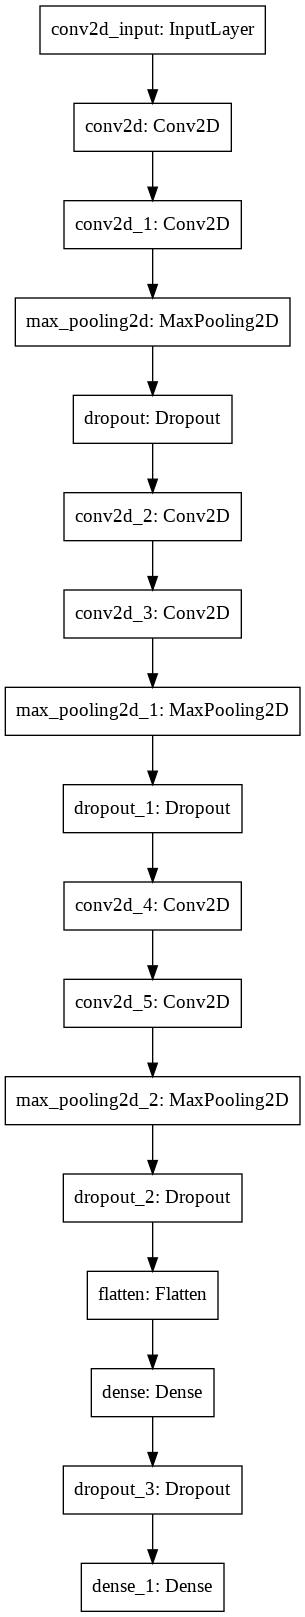

In [ ]:
plot_model(model, to_file='4th_model_architecture.png')

In [ ]:
model.compile(loss='categorical_crossentropy', 
              optimizer = Adam(lr=0.0001, beta_1=0.3, beta_2=0.777, epsilon=1e-03), 
              metrics = ['accuracy'])

datagen = ImageDataGenerator(rotation_range=15, 
                             zoom_range=0.2, 
                             width_shift_range=0.2, 
                             height_shift_range=0.2,
                             validation_split=0.20, 
                             horizontal_flip=True)

datagen.fit(X_train)

epochs = 40

m_hist = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                   epochs=epochs, verbose=1,
                   validation_data=(X_val, y_val),
                   shuffle=True,
                   steps_per_epoch = X_train.shape[0] // batch_size) # callbacks=[checkpoint]

model.save('models/4th_model.h5')

Epoch 1/40
233/233 [==============================] - 59s 253ms/step - loss: 0.9782 - accuracy: 0.5612 - val_loss: 0.9250 - val_accuracy: 0.5963
Epoch 2/40
233/233 [==============================] - 61s 261ms/step - loss: 0.9249 - accuracy: 0.5565 - val_loss: 0.7830 - val_accuracy: 0.6224
Epoch 3/40
233/233 [==============================] - 61s 260ms/step - loss: 0.8505 - accuracy: 0.5834 - val_loss: 0.7280 - val_accuracy: 0.6645
Epoch 4/40
233/233 [==============================] - 61s 261ms/step - loss: 0.7888 - accuracy: 0.6164 - val_loss: 0.6515 - val_accuracy: 0.6963
Epoch 5/40
233/233 [==============================] - 61s 261ms/step - loss: 0.7350 - accuracy: 0.6535 - val_loss: 0.6357 - val_accuracy: 0.7065
Epoch 6/40
233/233 [==============================] - 61s 261ms/step - loss: 0.6914 - accuracy: 0.6869 - val_loss: 0.5838 - val_accuracy: 0.7551
Epoch 7/40
233/233 [==============================] - 61s 260ms/step - loss: 0.6611 - accuracy: 0.7116 - val_loss: 0.5301 - val_ac

##Results of the model

In [ ]:
scores = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)
print("Test Accuracy : {0:.2f}%".format(scores[1]*100))
print("Loss Value : {0:.4f}".format(scores[0]))

67/67 [==============================] - 5s 82ms/step - loss: 0.2648 - accuracy: 0.9224
Test Accuracy : 92.24%
Loss Value : 0.2648


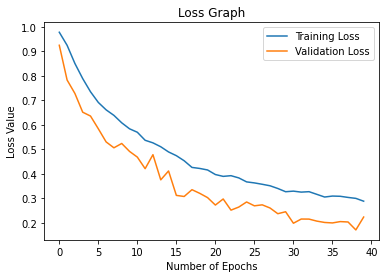

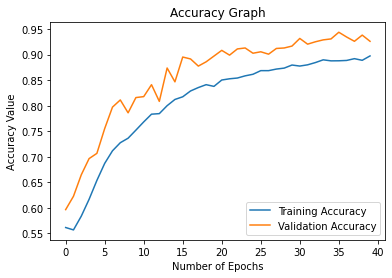

In [ ]:
# Plot Training and Validation Loss
plt.plot(m_hist.history['loss'], label = 'Training Loss')
plt.plot(m_hist.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss Value')
plt.title('Loss Graph')
plt.legend() #(['training', 'validation'], loc='lower right')
plt.show()


# Plot Training and Validation Accuracy
plt.plot(m_hist.history['accuracy'], label = 'Training Accuracy')
plt.plot(m_hist.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy Value')
plt.title('Accuracy Graph')
plt.legend() #(['training', 'validation'], loc='lower right')
plt.show()

In [ ]:
import warnings
warnings.filterwarnings("ignore")

y_pred = model.predict(X_test, batch_size=batch_size, verbose=0)
y_rounded_test = np.argmax(y_test, axis=1)
y_rounded_pred = np.argmax(y_pred, axis=1)

print(classification_report(y_rounded_test, y_rounded_pred, target_names=target_names)) # , digits=4

print(confusion_matrix(y_rounded_test, y_rounded_pred))
print('\n')

# Print f1, precision, and recall scores
print("Macro    : ", precision_recall_fscore_support(y_rounded_test, y_rounded_pred , average="macro"))
print("Micro    : ", precision_recall_fscore_support(y_rounded_test, y_rounded_pred , average="micro"))
print("Weighted : ", precision_recall_fscore_support(y_rounded_test, y_rounded_pred , average="weighted"))

                                 precision    recall  f1-score   support

            Class:0 - With Mask       0.95      0.92      0.94      1187
         Class:1 - Without Mask       0.88      0.91      0.90       535
Class:2 - Mask Weared Incorrect       0.90      0.93      0.92       418

                       accuracy                           0.92      2140
                      macro avg       0.91      0.92      0.92      2140
                   weighted avg       0.92      0.92      0.92      2140

[[1096   58   33]
 [  37  488   10]
 [  22    6  390]]


Macro    :  (0.9112228535262976, 0.922833342770181, 0.9168016683060914, None)
Micro    :  (0.922429906542056, 0.922429906542056, 0.922429906542056, None)
Weighted :  (0.9232831728263653, 0.922429906542056, 0.9226490441834984, None)


Confusion matrix, without normalization
[[1096   58   33]
 [  37  488   10]
 [  22    6  390]]


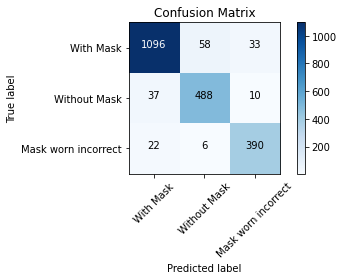

In [ ]:
cm = confusion_matrix(y_rounded_test, y_rounded_pred)

plot_confusion_matrix(cm, cm_plot_labels, title = 'Confusion Matrix')

In [ ]:
(1096+488+390)/2140

0.922429906542056

##Cross Validation

> loading only train sets for saving memory space





In [10]:
os.chdir("/content/drive/My Drive/Colab Notebooks/Face Mask Detector/Dataset/")

In [11]:
# For Loading Train files
pickle_in = open("X_train_X_853_2_3.pickle", "rb")
X_train = pickle.load(pickle_in)

pickle_in = open("y_train_y_853_2_3.pickle", "rb")
y_train = pickle.load(pickle_in)

In [12]:
model = load_model('models/4th_model.h5')

model.compile(loss='categorical_crossentropy', 
              optimizer = Adam(lr=0.0001, beta_1=0.3, beta_2=0.777, epsilon=1e-03), 
              metrics = ['accuracy'])

In [ ]:
def base_model():
  model = Sequential()

  model.add(Conv2D(filters=64, kernel_size=3, padding="same", activation = 'relu', input_shape=X_train.shape[1:]))
  model.add(Conv2D(64, kernel_size=3, activation='relu'))
  model.add(MaxPooling2D(pool_size=2))
  model.add(Dropout(0.25))

  model.add(Conv2D(filters=128, kernel_size=3, padding="same", activation = 'relu'))
  model.add(Conv2D(128, kernel_size=3, activation='relu'))
  model.add(MaxPooling2D(pool_size=2))
  model.add(Dropout(0.25))

  model.add(Conv2D(filters=64, kernel_size=3, padding="same", activation = 'relu'))
  model.add(Conv2D(32, kernel_size=3, activation='relu'))
  model.add(MaxPooling2D(pool_size=2))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(512, activation='relu'))

  model.add(Dropout(0.5))
  model.add(Dense(3, activation='softmax'))

  model.compile(loss='categorical_crossentropy', 
                optimizer = Adam(lr=0.0001, beta_1=0.3, beta_2=0.777, epsilon=1e-03), 
                metrics = ['accuracy'])

  return model

classifier = KerasClassifier(build_fn=base_model, epochs=15, batch_size=batch_size, verbose=1)
kfold = KFold(n_splits=5, shuffle=True)
cross_val_results = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv=kfold)
print('\n', cross_val_results)

Epoch 1/15
188/188 [==============================] - 41s 220ms/step - loss: 0.8594 - accuracy: 0.5977
Epoch 2/15
188/188 [==============================] - 43s 228ms/step - loss: 0.6329 - accuracy: 0.7236
Epoch 3/15
188/188 [==============================] - 45s 237ms/step - loss: 0.5224 - accuracy: 0.7802
Epoch 4/15
188/188 [==============================] - 44s 233ms/step - loss: 0.4489 - accuracy: 0.8165
Epoch 5/15
188/188 [==============================] - 44s 235ms/step - loss: 0.4080 - accuracy: 0.8348
Epoch 6/15
188/188 [==============================] - 44s 235ms/step - loss: 0.3681 - accuracy: 0.8539
Epoch 7/15
188/188 [==============================] - 44s 236ms/step - loss: 0.3356 - accuracy: 0.8707
Epoch 8/15
188/188 [==============================] - 44s 236ms/step - loss: 0.3008 - accuracy: 0.8891
Epoch 9/15
188/188 [==============================] - 44s 236ms/step - loss: 0.2786 - accuracy: 0.8940
Epoch 10/15
188/188 [==============================] - 44s 236ms/step - l

In [8]:
cross_val_results = [0.9126, 0.9038, 0.9038, 0.9025]

In [9]:
print('\n', "Accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(cross_val_results)*100, np.std(cross_val_results)*100))


 Accuracy: 90.57% (+/- 0.40%)


##Predictions



In [17]:
def predict_image(input_image):
  test_image = cv2.imread(input_image)
  test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
  test_image = cv2.resize(test_image, (img_rows,img_cols))
  cv2_imshow(test_image)
  test_image = image.img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis = 0)
  result = model.predict(test_image)
  label = np.argmax(result, axis=1)[0]
  categories = {0:'With_Mask', 1:'Without_Mask', 2:'With_Incorrect_Mask'}
  print('        ', result, '        ', categories[label])
  return

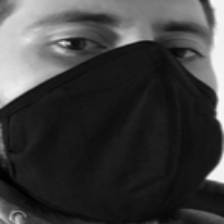

         [[0. 1. 0.]]          Without_Mask


In [20]:
predict_image('Test_images/test1.png')

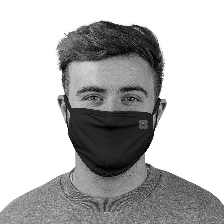

         [[0. 1. 0.]]          Without_Mask


In [21]:
predict_image('Test_images/test2.jpg')

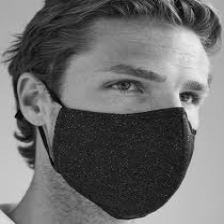

         [[1. 0. 0.]]          With_Mask


In [22]:
predict_image('Test_images/test3.jpg')

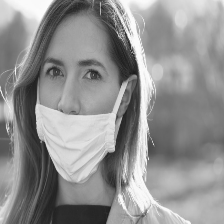

         [[1.0000000e+00 2.3324493e-17 0.0000000e+00]]          With_Mask


In [23]:
predict_image('Test_images/test4.jpg')

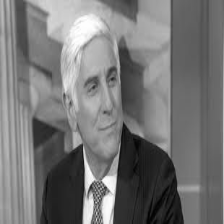

         [[0. 1. 0.]]          Without_Mask


In [24]:
predict_image('Test_images/test5.jpg')

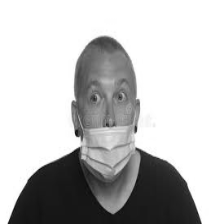

         [[0. 1. 0.]]          Without_Mask


In [25]:
predict_image('Test_images/test6.jpg')

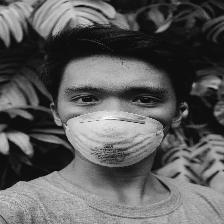

         [[0. 0. 1.]]          With_Incorrect_Mask


In [27]:
predict_image('Test_images/test7.jpg')

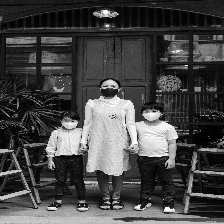

         [[1. 0. 0.]]          With_Mask


In [28]:
predict_image('Test_images/test8.jpg')

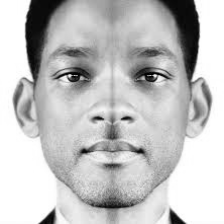

         [[1. 0. 0.]]          With_Mask


In [29]:
predict_image('Test_images/test9.jpg')

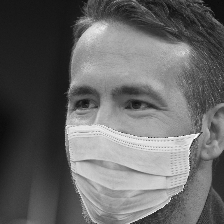

         [[1. 0. 0.]]          With_Mask


In [31]:
predict_image('Test_images/test10.jpg')

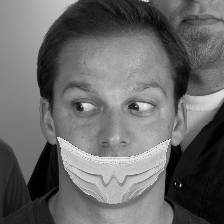

         [[1. 0. 0.]]          With_Mask


In [32]:
predict_image('Test_images/test11.jpg')

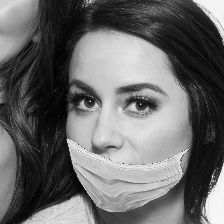

         [[1. 0. 0.]]          With_Mask


In [33]:
predict_image('Test_images/test12.jpg')

#**Extra Code**

In [ ]:
# Code for 112x112 lists

# Already saved. No need to run again. Change the name of the saved files in computer
# np.save("images_list.npy", images_list)
# np.save("labels_list.npy", labels_list)

# Run from here
# images_list = []
# labels_list = []
# images_list = np.load("images_list.npy")
# labels_list = np.load("labels_list.npy")
# images_list = np.array(images_list)/255.0
# images_list = np.resize(images_list, (images_list.shape[0], img_rows, img_cols, 1))
# labels_list = to_categorical(labels_list)
# labels_list = np.array(labels_list)

# print(labels_list.shape)
# print(type(labels_list))

# print(labels_list[:5],'\n')
# print(labels_list[3232:3236],'\n')
# print(labels_list[3949:3953])
# Till here

# Extras
# np.savetxt("labels_list.txt", labels_list,delimiter=',')
# np.savetxt('labels_list.txt', labels_list, fmt='%5s', delimiter=',')
# np.savetxt('labels_list.csv', labels_list, delimiter=',', fmt='%f', header=None)
# np.savetxt('labels_list.csv', labels_list, fmt='%.18e', delimiter=' ', newline='\n', header='', footer='', comments='# ', encoding=None)


In [ ]:
# Saving list to directory
# import csv
# with open(y, 'w', newline='') as myfile:
#   wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
#   wr.writerow(mylist)


# Saving array to directory - 1st method
# np.savetxt("y.csv", y, delimiter=",")

# Saving array to directory - 2nd method - Saves in one row and nultiple cols
# y.tofile('y.csv', sep=',',format='%10.5f')

In [ ]:
# np.save("full_data_224x224_list_format_shuffled.npy", full_data_224x224)

# full_data_224x224 = np.load("full_data_224x224_list_of_list_format_shuffled.npy", allow_pickle=True)

## 2nd Method of Pre-Processing - Incomplete

#####https://www.kaggle.com/notadithyabhat/face-mask-detector

In [ ]:
os.chdir("/content/drive/My Drive/Colab Notebooks/Face Mask Detector/")
Dataset = 'Dataset'
Data_Dir = os.listdir(Dataset)
print(Data_Dir)

In [ ]:
for dirname, _, filenames in os.walk('/content/drive/My Drive/Colab Notebooks/Face Mask Detector/Dataset'):
  for filename in filenames:
    print(os.path.join(dirname, filename))

In [ ]:
xml_files = et.parse('/content/drive/My Drive/Colab Notebooks/Face Mask Detector/Dataset/annotations/maksssksksss53.xml')
root_path = xml_files.getroot()

In [ ]:
print(len(root_path))

In [ ]:
for i in root_path:
  print(i)

In [ ]:
for child in root_path[2][0:2]:
  print(child.tag, child.text)

In [ ]:
sample_df = pd.DataFrame()
for file in os.listdir('/content/drive/My Drive/Colab Notebooks/Face Mask Detector/Dataset/annotations'):
  list = []
  xml_files = et.parse('/content/drive/My Drive/Colab Notebooks/Face Mask Detector/Dataset/annotations/' + file)
  root_path = xml_files.getroot()
  list.append((file, len(root_path)))
  cols = ['Image', 'Number of Objects']
  temp_df = pd.DataFrame(list, columns=cols)
  sample_df = sample_df.append(temp_df)
  sample_df.to_csv('sample_df.csv', index=False)

In [ ]:
pd.read_csv('sample_df.csv')
print(sample_df.sort_values('Number of Objects', ascending=False))

In [ ]:
datadict = {"Image": [], "Dimension": []}
for i in range(1, 116):
  datadict[f'Object {i}'] = []

for file in os.listdir('/content/drive/My Drive/Colab Notebooks/Face Mask Detector/Dataset/annotations'):
  row_list = []
  xml_files = et.parse('/content/drive/My Drive/Colab Notebooks/Face Mask Detector/Dataset/annotations/' + file) 
  root_path = xml_files.getroot() #https://docs.python.org/3/library/xml.etree.elementtree.html
  img = root_path[1].text
  row_list.append(img)
  h,w = root_path[2][0].text, root_path[2][1].text
  row_list.append([h,w])

  for i in range(4, len(root_path)):
    temp_list = []
    temp_list.append(root_path[i][0].text)
    for point in root_path[i][5]:
      temp_list.append(point.text)
    row_list.append(temp_list)
   
  #print(len(row_list))

  for i in range(len(row_list), 119):
    row_list.append(0)
        
  for i, each in enumerate(datadict):
    datadict[each].append(row_list[i])

In [ ]:
df = pd.DataFrame(datadict)
#df

#df.to_csv('df.csv', index=False)

In [ ]:
images_path = sorted(glob.glob(os.path.join("/content/drive/My Drive/Colab Notebooks/Face Mask Detector/Dataset/images","*.png")))
# for i in images_path:
#   print(i)

In [ ]:
classes = ["without_mask", "mask_weared_incorrect", "with_mask"]
# for (idx, item) in enumerate(classes, start=0):
#   print(idx, item)

In [ ]:
labels = []
data = []

In [ ]:
for idx, image in enumerate(images_path):
  img = cv2.imread(image)
  
  #if idx == 852:
  #  print(idx, img[0])
  
  #scale to dimension
  X,Y = df["Dimension"][idx]
  cv2.resize(img,(int(X), int(Y)))
  #print(idx, img.shape)

  #find the face in each object
  for obj in df.columns[3:]:
    #print(obj)
    info = df[obj][idx]
    #print(info)

    if info!=0:
      label = info[0]
      info[0]=info[0].replace(str(label), str(classes.index(label)))
      #print(info)

      info = [ int(each) for each in info ]
      #info = map(int, info)
      face = img[info[2]:info[4], info[1]:info[3]]
      try:
        face = cv2.resize(face,(224,224))  
        face = img_to_array(face)
        data.append(face)
        labels.append(label)
        if (label=="mask_weared_incorrect"):
          data.append(face)
          labels.append(label)
      except:
        pass

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(data[300])

In [ ]:
data = np.array(data, dtype="float32")
data = np.array(data)/255.0

#data

In [ ]:
labels = np.array(labels)
#labels

In [ ]:
print("Shape of Data List is:", data.shape)
print("Shape of Labels List is:", labels.shape)

#data = np.reshape(data1,(data1.shape[0], 224, 224, 3))

labels[2]

##3rd Method of Pre-Processing - Incomplete





In [ ]:
imagenames=[] #list of imagefile names
xmlnames=[] #list of xmlfile names
for dirname, _, filenames in os.walk('/content/drive/My Drive/Colab Notebooks/Face Mask Detector/Dataset'):
  for filename in filenames:
    if os.path.join(dirname, filename)[-3:]!="xml":
      imagenames.append(filename)
    else:
      xmlnames.append(filename)

In [ ]:
print(imagenames)

In [ ]:
print(xmlnames)

In [ ]:
path_im="/content/drive/My Drive/Colab Notebooks/Face Mask Detector/Dataset/images/"  #path for an image folder 
path_an="/content/drive/My Drive/Colab Notebooks/Face Mask Detector/Dataset/annotations/" #path for xmlfiles folder

In [ ]:
with open(path_an+xmlnames[0]) as f:
  print(xmltodict.parse(f.read()))

In [ ]:
# Code for finding the total no of labels in our dataset

listing=[]
for i in imagenames[:]:
  with open(path_an+i[:-4]+".xml") as fd:
    doc=xmltodict.parse(fd.read())
  
  temp=doc["annotation"]["object"]
  #print(len(temp))
  print(type(temp))

#   if type(temp) == list:                    # isinstance(temp, list)
#     for i in range(len(temp)):
#       listing.append(temp[i]["name"])
#     break
#   else:
#     pass
#     #listing.append(temp["name"])

# for i in listing:
#   print(i)

In [ ]:
options = {"with_mask":0,"without_mask":1,"mask_weared_incorrect":2} 
# mapping for predictions and analysis purpose

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_bounding_box(input_image): #function to visualize images
  with open(path_an + input_image[:-4] + ".xml") as fd:
    doc=xmltodict.parse(fd.read())
  image=plt.imread(os.path.join(path_im + input_image))
  fig,ax = plt.subplots(1)
  ax.axis("off")
  fig.set_size_inches(10,5)
  temp=doc["annotation"]["object"]
  if type(temp)=="list":
    for i in range(len(temp)):
      if temp[i]["name"]=="with_mask":
        a,b,c,d=list(map(int,temp[i]["bndbox"].values()))
        patch=patches.Rectangle((a,b),c-a,d-b,linewidth=1, edgecolor='g',facecolor="none",)
        ax.add_patch(patch)
      if temp[i]["name"]=="without_mask":
        a,b,c,d=list(map(int,temp[i]["bndbox"].values()))
        patch=patches.Rectangle((a,b),c-a,d-b,linewidth=1, edgecolor='r',facecolor="none",)
        ax.add_patch(patch)
      if temp[i]["name"]=="mask_weared_incorrect":
        a,b,c,d=list(map(int,temp[i]["bndbox"].values()))
        patch=patches.Rectangle((a,b),c-a,d-b,linewidth=1, edgecolor='y',facecolor="none",)
        ax.add_patch(patch)
  else:
    for i in range(len(temp)):
      if temp[i]["name"]:
        a,b,c,d = map(int, temp["bndbox"].values())
        edgecolor={"with_mask":"g","without_mask":"g","mask_weared_incorrect":"y"}
        patch=patches.Rectangle((a,b),d-b,c-a,linewidth=1, edgecolor=edgecolor[temp["name"]],facecolor="none",)

    

  ax.imshow(image)
  ax.add_patch(patch)

In [ ]:
for i in range(0,10):
  draw_bounding_box(imagenames[i])